In [4]:
import pandas as pd
import numpy as np


In [5]:
# Load the CSV file into a dataframe
df = pd.read_csv('tweet_emotions.csv')

# Print the shape of the datafra

In [6]:
# Print the shape of the dataframe
print(f"Dataset shape: {df.shape}")
print(f"Total rows: {df.shape[0]}, Total columns: {df.shape[1]}\n")

# Print column names and data types
print("Column names and data types:")
print(df.dtypes)
print()

# Print unique sentiments
print("Unique sentiments:")
print(df['sentiment'].unique())
print(f"Number of unique sentiments: {df['sentiment'].nunique()}\n")

# Print value counts for sentiments
print("Sentiment distribution:")
print(df['sentiment'].value_counts())
print()

# Print first few rows
print("First few rows:")
print(df.head())
print()

# Print general info
print("DataFrame info:")
df.info()

Dataset shape: (40000, 3)
Total rows: 40000, Total columns: 3

Column names and data types:
tweet_id      int64
sentiment    object
content      object
dtype: object

Unique sentiments:
['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']
Number of unique sentiments: 13

Sentiment distribution:
sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

First few rows:
     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm  

## Step 1: Text Preprocessing
Apply NLP preprocessing: lowercase, remove URLs, punctuation, numbers, tokenization, stopword removal, and lemmatization.

In [7]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Initialize
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Preprocess text for emotion classification."""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Stopword removal + Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Test preprocessing
sample = df['content'].iloc[0]
print(f"Original: {sample}")
print(f"Processed: {preprocess_text(sample)}")

Original: @tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[
Processed: know listenin bad habit earlier started freakin part


In [8]:
# Apply preprocessing to all text (this may take a minute)
print("Applying preprocessing to all tweets...")
df['processed_text'] = df['content'].apply(preprocess_text)
print("Done!")
print(f"\nSample preprocessed texts:")
print(df[['content', 'processed_text']].head(3))

Applying preprocessing to all tweets...
Done!

Sample preprocessed texts:
                                             content  \
0  @tiffanylue i know  i was listenin to bad habi...   
1  Layin n bed with a headache  ughhhh...waitin o...   
2                Funeral ceremony...gloomy friday...   

                                      processed_text  
0  know listenin bad habit earlier started freaki...  
1             layin n bed headache ughhhhwaitin call  
2                      funeral ceremonygloomy friday  


## Step 2: Train/Test Split & TF-IDF Vectorization

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Features and labels
X = df['processed_text']
y = df['sentiment']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"\nTF-IDF matrix shape: {X_train_tfidf.shape}")

Training samples: 32000
Testing samples: 8000

TF-IDF matrix shape: (32000, 5000)


## Step 3: Quick First-Cut Model (Multinomial Naive Bayes)
Fast baseline model to quickly check the pipeline works.

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Train Naive Bayes (fastest model)
print("Training Multinomial Naive Bayes...")
start = time.time()

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

train_time = time.time() - start
print(f"Training time: {train_time:.2f}s")

# Predict
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"\n✅ Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

Training Multinomial Naive Bayes...
Training time: 0.07s

✅ Naive Bayes Accuracy: 32.21%

Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       152
         fun       0.00      0.00      0.00       355
   happiness       0.37      0.28      0.32      1042
        hate       0.00      0.00      0.00       265
        love       0.57      0.27      0.37       768
     neutral       0.30      0.54      0.38      1728
      relief       0.00      0.00      0.00       305
     sadness       0.35      0.10      0.16      1033
    surprise       0.33      0.00      0.00       437
       worry       0.31      0.60      0.41      1692

    accuracy                           0.32      8000
   macro avg       0.17      0.14      0.13      8000
weighted avg       0.

d:\Code-Fusion\emotion-nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Code-Fusion\emotion-nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Code-Fusion\emotion-nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Step 4: Compare Multiple Models
Train and compare: Logistic Regression, SVM, Random Forest

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Store results
results = {
    'Model': ['Naive Bayes'],
    'Accuracy': [accuracy_nb],
    'Train Time (s)': [train_time]
}

# 1. Logistic Regression
print("=" * 50)
print("Training Logistic Regression...")
start = time.time()
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
lr_time = time.time() - start
y_pred_lr = lr_model.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Training time: {lr_time:.2f}s")
print(f"✅ Logistic Regression Accuracy: {accuracy_lr * 100:.2f}%")
results['Model'].append('Logistic Regression')
results['Accuracy'].append(accuracy_lr)
results['Train Time (s)'].append(lr_time)

# 2. Linear SVM (faster than kernel SVM)
print("\n" + "=" * 50)
print("Training Linear SVM...")
start = time.time()
svm_model = LinearSVC(max_iter=1000, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
svm_time = time.time() - start
y_pred_svm = svm_model.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Training time: {svm_time:.2f}s")
print(f"✅ Linear SVM Accuracy: {accuracy_svm * 100:.2f}%")
results['Model'].append('Linear SVM')
results['Accuracy'].append(accuracy_svm)
results['Train Time (s)'].append(svm_time)

# 3. Random Forest (smaller trees for speed)
print("\n" + "=" * 50)
print("Training Random Forest (100 trees)...")
start = time.time()
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
rf_time = time.time() - start
y_pred_rf = rf_model.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Training time: {rf_time:.2f}s")
print(f"✅ Random Forest Accuracy: {accuracy_rf * 100:.2f}%")
results['Model'].append('Random Forest')
results['Accuracy'].append(accuracy_rf)
results['Train Time (s)'].append(rf_time)

Training Logistic Regression...
Training time: 5.13s
✅ Logistic Regression Accuracy: 35.01%

Training Linear SVM...
Training time: 3.37s
✅ Linear SVM Accuracy: 32.44%

Training Random Forest (100 trees)...
Training time: 0.68s
✅ Random Forest Accuracy: 30.36%


## Step 5: Model Comparison Summary

In [12]:
import matplotlib.pyplot as plt

# Create comparison DataFrame
results_df = pd.DataFrame(results)
results_df['Accuracy %'] = results_df['Accuracy'] * 100
results_df = results_df.sort_values('Accuracy', ascending=False)

print("=" * 60)
print("📊 MODEL COMPARISON SUMMARY")
print("=" * 60)
print(results_df[['Model', 'Accuracy %', 'Train Time (s)']].to_string(index=False))
print("=" * 60)

# Find best model
best_model = results_df.iloc[0]
print(f"\n🏆 Best Model: {best_model['Model']} with {best_model['Accuracy %']:.2f}% accuracy")

📊 MODEL COMPARISON SUMMARY
              Model  Accuracy %  Train Time (s)
Logistic Regression     35.0125        5.130284
         Linear SVM     32.4375        3.370012
        Naive Bayes     32.2125        0.070122
      Random Forest     30.3625        0.675106

🏆 Best Model: Logistic Regression with 35.01% accuracy


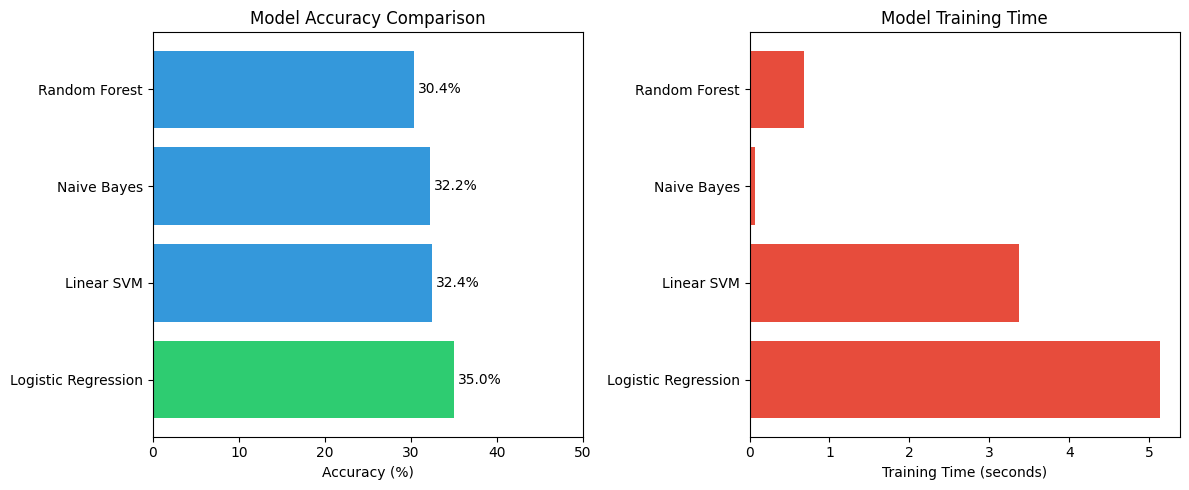

In [13]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
colors = ['#2ecc71' if acc == max(results['Accuracy']) else '#3498db' for acc in results_df['Accuracy']]
bars = axes[0].barh(results_df['Model'], results_df['Accuracy %'], color=colors)
axes[0].set_xlabel('Accuracy (%)')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xlim(0, 50)
for bar, acc in zip(bars, results_df['Accuracy %']):
    axes[0].text(acc + 0.5, bar.get_y() + bar.get_height()/2, f'{acc:.1f}%', va='center')

# Training time comparison  
axes[1].barh(results_df['Model'], results_df['Train Time (s)'], color='#e74c3c')
axes[1].set_xlabel('Training Time (seconds)')
axes[1].set_title('Model Training Time')

plt.tight_layout()
plt.show()

## Step 6: Best Model - Detailed Metrics (Logistic Regression)

In [15]:
import seaborn as sns

📈 LOGISTIC REGRESSION - DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       1.00      0.03      0.05        36
       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       152
         fun       0.29      0.03      0.06       355
   happiness       0.34      0.35      0.35      1042
        hate       0.46      0.12      0.19       265
        love       0.52      0.40      0.46       768
     neutral       0.33      0.56      0.41      1728
      relief       0.24      0.03      0.06       305
     sadness       0.35      0.25      0.29      1033
    surprise       0.25      0.03      0.06       437
       worry       0.34      0.49      0.40      1692

    accuracy                           0.35      8000
   macro avg       0.32      0.18      0.18      8000
weighted avg       0.34      0.35      0.32      8000



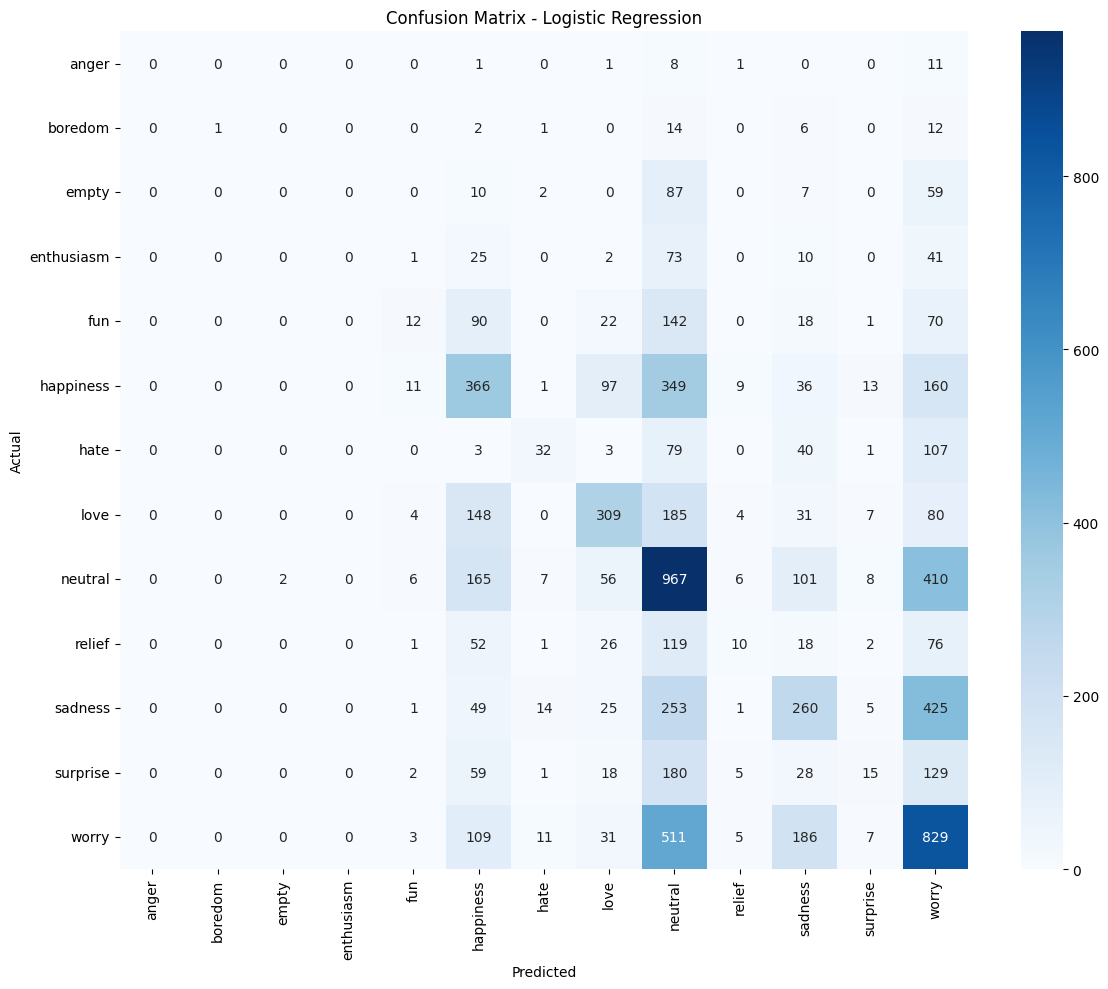

In [16]:
import seaborn as sns

# Best model detailed report
print("=" * 60)
print("📈 LOGISTIC REGRESSION - DETAILED CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred_lr, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_lr, labels=lr_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

## Step 7: Save Best Model for Flask App

In [17]:
import joblib
import os

# Create model directory
os.makedirs('model', exist_ok=True)

# Save the best model (Logistic Regression) and TF-IDF vectorizer
joblib.dump(lr_model, 'model/emotion_model.pkl')
joblib.dump(tfidf, 'model/tfidf_vectorizer.pkl')

print("✅ Model saved to: model/emotion_model.pkl")
print("✅ Vectorizer saved to: model/tfidf_vectorizer.pkl")
print("\n🚀 You can now run the Flask app with: python app.py")

✅ Model saved to: model/emotion_model.pkl
✅ Vectorizer saved to: model/tfidf_vectorizer.pkl

🚀 You can now run the Flask app with: python app.py
